In [ ]:
import os
import glob
import torch 
import numpy as np
import matplotlib.pyplot as plt
import types
import pandas as pd
import json
from merlin_standard_lib import Schema
from datetime import datetime
from transformers4rec.torch.utils.examples_utils import wipe_memory

In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
SCHEMA_PATH = "sample_schema2.pb"
OVERWRITE_SCHEMA = True
mapping_path="maps"
min_item_number = 4
category_cols = ["event_type", "product_id", "category_code","brand"]
group_cols = category_cols + ["price", "rel_time"]

In [4]:
def categorify_col(df,column,save_path=None):
    """
    Replace column with an index mapped column, so a, b, c, becomes 1, 2, 3. 
    
    :params df: Dataframe to do mapping on, data frame is changed in place
    :param column: name of column to do mapping on. 
    :param save_path: directory to save columns in, will not create by default, if None, mappings are not saved. 
    
    
    
    :return: Pandas series with index to value mapping. The index of the series is the value that will be used in the dataframe. 
    
    """
    

    print(column)
    df_col = pd.Series(df[column].unique())
    df_col.index+=1 #index needs to start at 1, not 0
    df[column] = df[column].map(df_col.reset_index().set_index(0)["index"])
    if save_path:
        path = os.path.join(save_path,column)+".json"
        with open(path, 'w') as fp:      
            json.dump(dict(df_col), fp)
    return df_col

In [5]:
df_raw = pd.read_parquet("/home/ec2-user/SageMaker/t4rec_daily/Oct-2019.parquet")

In [ ]:
print("Count with in-session repeated interactions: {}".format(len(df)))



df = df.sort_values(["user_session", "rel_time"])



# Keeping only no consecutive repeated in session interactions
session_is_last_session = df["user_session"] == df["user_session"].shift(1)
item_is_last_item = df["product_id"] == df["product_id"].shift(1)
df = df[~(session_is_last_session & item_is_last_item)]



print("Count after removed in-session repeated interactions: {}".format(len(df)))

In [6]:
df = df_raw.copy()

In [7]:
df = df.sort_values(['event_time_ts'], ascending=True)

In [8]:
df["rel_time"] = df.event_time_ts - df.prod_first_event_time_ts
df.rel_time = df.rel_time.astype(float)

#change these int64 to float so that I can save the json files
df.product_id = df.product_id.astype(float)

In [9]:
if not os.path.exists(mapping_path):
    os.mkdir(mapping_path)
for col in category_cols:
    categorify_col(df,col,save_path=mapping_path)

event_type
product_id
category_code
brand


In [10]:
%%time
df_group_train = df.groupby('user_session').agg(lambda x: list(x)[:-2])
df_group_valid = df.groupby('user_session').agg(lambda x: list(x)[-2:])

CPU times: user 5min 55s, sys: 6.12 s, total: 6min 1s
Wall time: 6min 1s


In [57]:
df_group_train.head()

,user_session,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_ts,prod_first_event_time_ts,rel_time,len
0,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11927, 12665, 13080, 17698, 17799, 6982, 5047...","[2053013553559896355, 2053013553559896355, 205...","[2, 2, 2, 2, 2, 41, 41, 41, 41, 41, 41, 41, 41...","[771, 223, 678, 457, 537, 144, 34, 144, 729, 6...","[70.79, 72.07, 72.59, 45.449999999999996, 68.2...","[513605798, 513605798, 513605798, 513605798, 5...","[1569900208, 1569900523, 1569900702, 156990268...","[1569900208, 1569900523, 1569900686, 156990268...","[0.0, 0.0, 16.0, 0.0, 0.0, 4794.0, 5491.0, 676...",777
1,6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[35, 2194, 20687, 1816, 35, 219, 2805, 444, 55...","[2053013558282682943, 2053013557133443581, 205...","[2, 49, 49, 9, 2, 2, 49, 3, 49, 49, 49, 49, 49...","[3, 3, 3, 3, 3, 45, 3, 3, 14, 3, 3, 14, 45, 3,...","[399.72999999999996, 255.06, 211.56, 155.19, 3...","[491844619, 491844619, 491844619, 491844619, 4...","[1569996656, 1569996695, 1569996721, 156999673...","[1569888028, 1569896860, 1569904145, 156989673...","[108628.0, 99835.0, 92576.0, 100008.0, 108735....",314
2,17,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8318, 1073, 11009, 9691, 17, 5619, 4099, 6652...","[2053013554415534427, 2053013554415534427, 205...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[149, 149, 1053, 1053, 13, 13, 13, 13, 13, 46,...","[488.82, 436.82, 437.33, 360.09, 193.03, 244.5...","[513068111, 513068111, 513068111, 513068111, 5...","[1570129949, 1570130026, 1570130059, 157013007...","[1569898863, 1569896451, 1569899857, 156989937...","[231086.0, 233575.0, 230202.0, 230703.0, 24207...",128
3,22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5679, 1010, 13057, 4513, 19276, 17524, 514, 4...","[2053013553945772349, 2053013553945772349, 205...","[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4...","[808, 49, 3, 144, 144, 53, 49, 688, 144, 151, ...","[15.44, 74.64999999999999, 144.15, 88.01, 48.6...","[522539566, 522539566, 522539566, 522539566, 5...","[1570013306, 1570013317, 1570013329, 157001334...","[1569897921, 1569896429, 1569900678, 156989755...","[115385.0, 116888.0, 112651.0, 115791.0, 10995...",275
4,26,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41561, 29934, 80103, 31750, 25860, 34761, 557...","[2053013563743667055, 2053013563743667055, 205...","[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8...","[1192, 15, 1777, 1777, 31, 67, 67, 1192, 3, 35...","[215.14, 247.26999999999998, 185.7699999999999...","[512805595, 512805595, 512805595, 512805595, 5...","[1570288849, 1570288891, 1570288961, 157028906...","[1569919477, 1569909801, 1570020265, 156991101...","[369372.0, 379090.0, 268696.0, 378052.0, 38183...",143


In [11]:
df_group_train = df_group_train.reset_index()
df_group_valid = df_group_valid.reset_index()

In [12]:
df_group_train['len'] = df_group_train['event_type'].apply(len)
df_group_valid['len'] = df_group_valid['event_type'].apply(len)

In [13]:
df_group_train = df_group_train[df_group_train.len >= 2]

In [14]:
df_group_valid = df_group_valid[df_group_valid.user_session.isin(df_group_train.user_session)]

In [15]:
def schema_maker(df, name,tag,data_type=None):
    """
    Helper function to create parts of the schema file required to set up the t4rec models. Call this once for 
    each column you would like to add to the schema, then append these dictionaries as a list. 
    
    Usage:
    
        schema_base = {"user_session":{"tag":["group_col"]},
                   "product_id":{"tag":["categorical","list","item_id"]},
                  "category_code":{"tag":["categorical","list"]},
                  "brand":{"tag":["categorical","list"]},
                  "rel_time":{"tag":["continuous","list"],"data_type":float}
                  }
        schema_list = [schema_maker(df_train, key,**val) for (key,val) in schema_base.items()]

        schema = Schema().from_dict({"feature":schema_list})
        with open(SCHEMA_PATH,"wt") as f:
            f.write(schema.to_proto_text())
        
        
        
    
    :param df: Pandas dataframe were columns reside. Required for getting column value ranges for the schema
    :param name(str): column name to be used 
    :param tags (List[str]): List of tags to be used in the annotation for this column. 
    :param data_type: datatype for the column. Will be default try to detect based on df.dtypes. 
    
    :return: dictionary for schema of one of the columns. 
    
    """
    data_type = data_type if data_type else df.dtypes[name]
    out_dict = {"name":name,"annotation":{"tag":tag}}
    if data_type == int:
        out_dict["type"] = "INT"
        out_dict["int_domain"] = {"name":name,
                                 "min":str(df[name].min()),
                                 "max":str(df[name].max())}
        if "categorical" in tag:
            out_dict["int_domain"]["is_categorical"] = True
            out_dict["value_count"] = {'min': '2', 'max': '20'}
    if data_type == float:
        out_dict["type"] = "FLOAT"
        min_val = df[name].min()
        min_val = min_val if min_val !=0 else min_val+1
        out_dict["float_domain"]= {"name":name,
                                 "min":min_val,
                                 "max":df[name].max()}
    return out_dict

In [16]:
if not os.path.exists(SCHEMA_PATH) or OVERWRITE_SCHEMA:

    schema_base = {"user_session":{"tag":["group_col"]},
                   "product_id":{"tag":["categorical","list","item_id"],},
                  "category_code":{"tag":["categorical","list"]},
                  "brand":{"tag":["categorical","list"]},
                  "rel_time":{"tag":["continuous","list"],"data_type":float},
                   "price":{"tag":["continuous","list"],"data_type":float}
                  }
    schema_list = [schema_maker(df, key,**val) for (key,val) in schema_base.items()]

    schema = Schema().from_dict({"feature":schema_list})
    with open(SCHEMA_PATH,"wt") as f:
        f.write(schema.to_proto_text())
else:
    schema = Schema().from_proto_text(SCHEMA_PATH)


In [17]:
df_group_train.to_parquet("sample_train.parquet",index=False)
df_group_valid.to_parquet("sample_val.parquet",index=False)

In [19]:
df_group_valid.shape

(500443, 12)

In [18]:
df_group_train.shape

(500443, 12)

In [ ]:
ts = 1570492799

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts))

In [32]:
count = df.groupby('product_id')['user_session'].count()

In [ ]:
[ 89,  55,  72, 114,  43,  51,  69,  19, 105, 100]

In [58]:
count.reset_index().sort_values('user_session', ascending=False).reset_index(drop=True).head(20)

,product_id,user_session
0,89,66805
1,72,61069
2,43,49598
3,55,37483
4,114,36222
5,69,28874
6,51,28167
7,280,25963
8,335,25901
9,122,24594


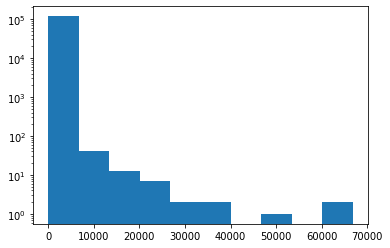

In [37]:
plt.hist(count, log=True);